# **Practice for DLRM PyTorch**

## **1. Installation**



In [1]:
!nvidia-smi

Thu Aug 22 11:42:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:01:00.0 Off |                  N/A |
| 31%   34C    P8              11W / 170W |    181MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install torch
!apt-get install unzip
!pip3 install pandas implicit sklearn onnx "git+https://github.com/mlperf/logging.git" surgeon-pytorch pandas scipy multiprocess
!git clone https://github.com/facebookresearch/dlrm

DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning https://github.com/mlperf/logging.git to /tmp/pip-req-build-uluh6w9j
  Running command git clone --filter=blob:none --quiet https://github.com/mlperf/logging.git /tmp/pip-req-build-uluh6w9j
  Resolved https://github.com/mlperf/logging.git to commit 369260bf8326f36f644d34a1996b05ec51ad9717
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error:

In [3]:
import torch
print("import succeed")

import succeed


## **2. DLRM PyTorch**
- DLRM Paper : https://arxiv.org/abs/1906.00091


In [4]:
cd dlrm

/home/devrok/aiexpert/ai-system/Workloads/dlrm


- Example model architecture :
<br/>
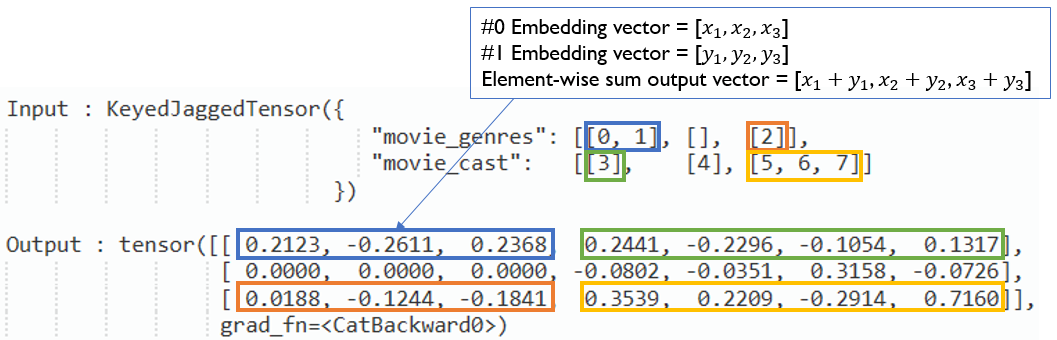

In [5]:
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu

Unable to import mlperf_logging,  No module named 'mlperf_logging'
Unable to import onnx.  No module named 'onnx'
world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of epoch 0, -1.00 ms/it, loss 0.207687
Finished training it 2/5 of epoch 0, -1.00 ms/it, loss 0.091614
Finished training it 3/5 of epoch 0, -1.00 ms/it, loss 0.073226
Finished training it 4/5 of epoch 0, -1.00 ms/it, loss 0.039275
Finished training it 5/5 of epoch 0, -1.00 ms/it, loss 0.009234


In [6]:
import dlrm_s_pytorch as s
import numpy as np

dlrm = s.DLRM_Net(
    m_spa=16,
    ln_emb=np.array([100,100]),
    ln_bot=np.array([13,64,16]),
    ln_top=np.array([19,16,8,4,1]),
    arch_interaction_op="dot", # {"dot" / "cat"}
    arch_interaction_itself=False,
    qr_flag=False,
    md_flag=False,
)

dlrm

Unable to import mlperf_logging,  No module named 'mlperf_logging'
Unable to import onnx.  No module named 'onnx'


DLRM_Net(
  (emb_l): ModuleList(
    (0-1): 2 x EmbeddingBag(100, 16, mode='sum')
  )
  (bot_l): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (top_l): Sequential(
    (0): Linear(in_features=19, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): ReLU()
  )
  (loss_fn): BCELoss()
)

- Input data format :
<br/>
<img src="https://drive.google.com/uc?id=1JGJMtMFa9gw0Zy_GFak7Bvc5tY3kcc8y" width=600>


In [7]:
dense_x = torch.rand(2, 13)
sparse_offsets = [torch.LongTensor([0,4]), torch.LongTensor([0,4])]
sparse_indices = [torch.LongTensor([9,23,29,62,31,42,43,49]), torch.LongTensor([50,62,88,93,31])]

dlrm(dense_x, sparse_offsets, sparse_indices)

tensor([[1.5251],
        [1.6455]], grad_fn=<ReluBackward0>)

## **3. Memory-efficient embedding techniques**

### **Quotient Remainder Trick**
- Paper : https://arxiv.org/pdf/1909.02107.pdf



In [8]:
import tricks.qr_embedding_bag as qr
qr_emb = qr.QREmbeddingBag(num_categories=100, embedding_dim=16, num_collisions=3)

qr_emb.weight_q.shape, qr_emb.weight_r.shape

(torch.Size([34, 16]), torch.Size([3, 16]))

In [9]:
print(sparse_indices[0])
print(sparse_offsets[0])
print(qr_emb(sparse_indices[0], sparse_offsets[0]).shape)

tensor([ 9, 23, 29, 62, 31, 42, 43, 49])
tensor([0, 4])
torch.Size([2, 16])


- Run DLRM with `QREmbeddingBag`
  - QR Trick applied to embedding table which row size is bigger than `--qr-threshold`

In [10]:
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu \
                          --qr-flag --qr-threshold 50 --qr-operation mult --qr-collisions 3

Unable to import mlperf_logging,  No module named 'mlperf_logging'
Unable to import onnx.  No module named 'onnx'
world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of epoch 0, -1.00 ms/it, loss 0.095611
Finished training it 2/5 of epoch 0, -1.00 ms/it, loss 0.227742
Finished training it 3/5 of epoch 0, -1.00 ms/it, loss 0.080723
Finished training it 4/5 of epoch 0, -1.00 ms/it, loss 0.199807
Finished training it 5/5 of epoch 0, -1.00 ms/it, loss 0.693947


### **Mixed Dimension Trick**
- Paper : https://arxiv.org/pdf/1909.11810.pdf

<img src="https://drive.google.com/uc?id=1tWC9Sr9wWi5ddz-x9Xi6I0pQU9VRJKlp" width=500>

In [ ]:
import tricks.md_embedding_bag as md

md.md_solver(
    torch.Tensor([100,200,300,400]),
    alpha=1.0,
    d0=128,
    round_dim=False,
)

tensor([128,  64,  43,  32])

In [ ]:
ud_emb_1 = md.PrEmbeddingBag(num_embeddings=100, embedding_dim=128, base_dim=128)
ud_emb_2 = md.PrEmbeddingBag(num_embeddings=200, embedding_dim=64, base_dim=128)
ud_emb_3 = md.PrEmbeddingBag(num_embeddings=300, embedding_dim=43, base_dim=128)
ud_emb_4 = md.PrEmbeddingBag(num_embeddings=400, embedding_dim=32, base_dim=128)

ud_emb_1, ud_emb_2, ud_emb_3, ud_emb_4

(PrEmbeddingBag(
   (embs): EmbeddingBag(100, 128, mode='sum')
   (proj): Identity()
 ),
 PrEmbeddingBag(
   (embs): EmbeddingBag(200, 64, mode='sum')
   (proj): Linear(in_features=64, out_features=128, bias=False)
 ),
 PrEmbeddingBag(
   (embs): EmbeddingBag(300, 43, mode='sum')
   (proj): Linear(in_features=43, out_features=128, bias=False)
 ),
 PrEmbeddingBag(
   (embs): EmbeddingBag(400, 32, mode='sum')
   (proj): Linear(in_features=32, out_features=128, bias=False)
 ))

\* `mode='sum'` : do element-wise addition for look-uped vectors

In [ ]:
print(sparse_indices[0])
print(sparse_offsets[0])
print(ud_emb_1(sparse_indices[0], sparse_offsets[0]).shape)
print("------------------------")
print(sparse_indices[1])
print(sparse_offsets[1])
print(ud_emb_2(sparse_indices[1], sparse_offsets[1]).shape)

tensor([ 9, 23, 29, 62, 31, 42, 43, 49])
tensor([0, 4])
torch.Size([2, 128])
------------------------
tensor([50, 62, 88, 93, 31])
tensor([0, 4])
torch.Size([2, 128])


- Run DLRM with `PrEmbeddingBag`
  - MD Trick applied to embedding table which row size is bigger than `--md-threshold`

In [ ]:
!python dlrm_s_pytorch.py --arch-sparse-feature-size=16 --arch-embedding-size="100-100" --arch-mlp-bot="13-64-16" --arch-mlp-top="16-8-4-1" \
                          --data-generation random --mini-batch-size=2 --data-size=10 \
                          --use-gpu \
                          --md-flag --md-threshold 50 --md-temperature 0.3

Unable to import mlperf_logging,  No module named 'mlperf_logging'
2024-08-16 05:15:22.232297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 05:15:22.251588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 05:15:22.257642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 05:15:23.430842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Unable to import onnx.  No module named 'onnx'
world size: 1, current rank: 0, local rank: 0
Using 1 GPU(s)...
time/loss/accuracy (if enabled):
Finished training it 1/5 of ep

### **Deep Hash Embedding**
- Paper : https://arxiv.org/pdf/2010.10784.pdf

In [ ]:
!git clone https://github.com/samhsia/MP-Rec-AE.git

Cloning into 'MP-Rec-AE'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 104 (delta 29), reused 99 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 121.56 KiB | 7.60 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
cd MP-Rec-AE/dlrm_mprec

/content/dlrm/MP-Rec-AE/dlrm_mprec


- Before you run :
1. Open file /content/dlrm/MP-Rec-AE/dlrm_mprec/dhebag.py
2. put comment(#) on L5 : `from primesieve import nth_prime`
3. put comment(#) on L103 : `p = nth_prime(1, args_dhe["m"])`
4. remove comment(#) on L104 : `# p = self.next_prime(args_dhe['m'])`
5. Save file (ctrl+c)

- DHE archtecture :
<br>
<img src="https://drive.google.com/uc?id=1Dmm9zI62ew_b4F015mvl4aW2fAntXTH0" width=800>

In [ ]:
import dhebag as d
import numpy as np

table_sizes = [100, 200]
args_dhe = {
    "k" : 1024, # {2 ~ 2048}
    "hash_fn" : 'universal',
    "m" : 1000000,
    "seed" : 0,
    "transform" : 'uniform', # {'uniform' / 'gaussian'}
    "precision" : np.float32,
    "mlp_dims" : np.fromstring('1024-128-128', dtype=int, sep="-"), # {dhe_k - hidden_dim.- hidden_dim.- embed_vector_dim.}
    "activation" : 'mish', # {'relu' / 'sigmoid' / 'mish'}
    "batch_norm" : True,
    "num_lookups" : 2, # == len(sparse_offsets[0])
}
dhe = d.DHEBag(table_sizes, args_dhe)

dhe

<class 'numpy.float32'>


DHEBag(
  (hash_params): ParameterList(
      (0): Parameter containing: [torch.int64 of size 1024x4]
      (1): Parameter containing: [torch.int64 of size 1024x4]
  )
  (dhe_mlps): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Mish()
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [ ]:
sparse_offsets = [torch.LongTensor([0,4]), torch.LongTensor([0,4])]
sparse_indices = [torch.LongTensor([9,23,29,62,31,42,43,49]), torch.LongTensor([50,62,88,93,31])]

result = dhe(sparse_offsets, sparse_indices)
print("result from 1st Embedding table (DHE) : ", result[0].shape)
print("result from 2nd Embedding table (DHE) : ", result[1].shape)

result from 1st Embedding table (DHE) :  torch.Size([2, 128])
result from 2nd Embedding table (DHE) :  torch.Size([2, 128])


# **Practice for DLRM TorchRec**

## **1. Installation**

In [ ]:
!pip3 install --pre torch --index-url https://download.pytorch.org/whl/nightly/cu121 -U
!pip3 install fbgemm_gpu --index-url https://download.pytorch.org/whl/nightly/cu121
!pip3 install torchmetrics==1.0.3
!pip3 install torchrec --index-url https://download.pytorch.org/whl/nightly/cu121
!pip3 install fvcore
!pip3 install pyre-extensions

Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.0/331.0 MB 4.5 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.8/586.8 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchrec to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.7/586.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.6/584.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.3 MB/s eta 0:00:0

## **2. TorchRec primitive classes**

### ***KeyedJaggedTensor***
  - A KeyedJaggedTensor is a tensor with a jagged dimension which is dimension whose slices may be of different lengths. Keyed on first dimension and jagged on the last dimension.
  - `offsets=torch.tensor([0, 2, 2, 3, 4, 5, 8]) -> values[0:2]; values[2:2]; values[2:3]; values[3:4]; ...`


In [ ]:
import torch
import torchrec

#                  0      1     2  <-- batch
# "movie_genres"   [0,1]  None  [2]
# "movie_cast"     [3]    [4]   [5,6,7]
#  ^
# feature

features = torchrec.KeyedJaggedTensor(
    keys=["movie_genres", "movie_cast"],
    values=torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]),
    offsets=torch.tensor([0, 2, 2, 3, 4, 5, 8]),
)

print(features)

KeyedJaggedTensor({
    "movie_genres": [[0, 1], [], [2]],
    "movie_cast": [[3], [4], [5, 6, 7]]
})



### ***EmbeddingBagConfig & EmbeddingBagCollection***
<br>
  <img src="https://drive.google.com/uc?id=1_7GoRS1R3JZiAX4CrQPqHnvdFeMeGxm6" width=600>

In [ ]:
from torchrec.modules.embedding_configs import EmbeddingBagConfig
from torchrec import EmbeddingBagCollection

table_0 = EmbeddingBagConfig(
    name="genres_embedding", embedding_dim=3, num_embeddings=10, feature_names=["movie_genres"]
)
table_1 = EmbeddingBagConfig(
    name="actor_embedding", embedding_dim=4, num_embeddings=10, feature_names=["movie_cast"]
)

ebc = EmbeddingBagCollection(tables=[table_0, table_1])
print(ebc)
print("input :", features)
pooled_embeddings = ebc(features)
print("output :", pooled_embeddings.values())

EmbeddingBagCollection(
  (embedding_bags): ModuleDict(
    (genres_embedding): EmbeddingBag(10, 3, mode='sum')
    (actor_embedding): EmbeddingBag(10, 4, mode='sum')
  )
)
input : KeyedJaggedTensor({
    "movie_genres": [[0, 1], [], [2]],
    "movie_cast": [[3], [4], [5, 6, 7]]
})

output : tensor([[-8.4787e-02,  9.4152e-02, -1.6164e-04,  3.3712e-02, -1.8042e-01,
          1.5296e-01, -1.6182e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.6526e-02,  2.1258e-01,
         -3.9344e-02, -2.7806e-01],
        [ 7.9546e-02,  1.3619e-01,  7.1994e-02,  2.1880e-01,  2.8135e-01,
          6.0473e-01, -1.8713e-01]], grad_fn=<CatBackward0>)


### ***DLRM & DLRMTrain***

In [ ]:
from torchrec.models.dlrm import DLRM, DLRMTrain
from torchrec.datasets.criteo import DEFAULT_INT_NAMES, DEFAULT_CAT_NAMES
from torchrec.modules.embedding_configs import EmbeddingBagConfig
from torchrec import EmbeddingBagCollection


num_embeddings_per_feature = [100*i for i in range(1, 27)] # == [100, 200, ..., 2600]
eb_configs = [
                  EmbeddingBagConfig(
                      name=f"t_{feature_name}",
                      embedding_dim=64,
                      num_embeddings=num_embeddings_per_feature[feature_idx],
                      feature_names=[feature_name],
                  )
                  for feature_idx, feature_name in enumerate(DEFAULT_CAT_NAMES)
              ]

dlrm_model = DLRM(
                    embedding_bag_collection=EmbeddingBagCollection(
                        tables=eb_configs, device=torch.device("meta")
                    ),
                    dense_in_features=len(DEFAULT_INT_NAMES),
                    dense_arch_layer_sizes=[512,256,64],
                    over_arch_layer_sizes=[512,512,256,1],
                    dense_device="cuda:0",
                  )

train_model = DLRMTrain(dlrm_model)
train_model

DLRMTrain(
  (model): DLRM(
    (sparse_arch): SparseArch(
      (embedding_bag_collection): EmbeddingBagCollection(
        (embedding_bags): ModuleDict(
          (t_cat_0): EmbeddingBag(100, 64, mode='sum')
          (t_cat_1): EmbeddingBag(200, 64, mode='sum')
          (t_cat_2): EmbeddingBag(300, 64, mode='sum')
          (t_cat_3): EmbeddingBag(400, 64, mode='sum')
          (t_cat_4): EmbeddingBag(500, 64, mode='sum')
          (t_cat_5): EmbeddingBag(600, 64, mode='sum')
          (t_cat_6): EmbeddingBag(700, 64, mode='sum')
          (t_cat_7): EmbeddingBag(800, 64, mode='sum')
          (t_cat_8): EmbeddingBag(900, 64, mode='sum')
          (t_cat_9): EmbeddingBag(1000, 64, mode='sum')
          (t_cat_10): EmbeddingBag(1100, 64, mode='sum')
          (t_cat_11): EmbeddingBag(1200, 64, mode='sum')
          (t_cat_12): EmbeddingBag(1300, 64, mode='sum')
          (t_cat_13): EmbeddingBag(1400, 64, mode='sum')
          (t_cat_14): EmbeddingBag(1500, 64, mode='sum')
         

### ***EmbeddingShardingPlanner***


In [ ]:
from torchrec.distributed.planner import *
from torchrec.distributed.sharding_plan import get_default_sharders

topology = Topology(
    local_world_size=2,
    world_size=4,
    compute_device="cuda"
)

planner = EmbeddingShardingPlanner(
        topology=topology,
        batch_size=256,
    )

plan = planner.plan(train_model, get_default_sharders())

print(plan)

module: model.sparse_arch.embedding_bag_collection

 param   | sharding type  | compute kernel |    ranks    
-------- | -------------- | -------------- | ------------
t_cat_0  | data_parallel  | dense          | [0, 1, 2, 3]
t_cat_1  | data_parallel  | dense          | [0, 1, 2, 3]
t_cat_2  | table_row_wise | fused          | [2, 3]      
t_cat_3  | table_row_wise | fused          | [0, 1]      
t_cat_4  | table_row_wise | fused          | [2, 3]      
t_cat_5  | table_row_wise | fused          | [0, 1]      
t_cat_6  | table_row_wise | fused          | [2, 3]      
t_cat_7  | table_row_wise | fused          | [0, 1]      
t_cat_8  | table_row_wise | fused          | [2, 3]      
t_cat_9  | table_row_wise | fused          | [0, 1]      
t_cat_10 | table_row_wise | fused          | [2, 3]      
t_cat_11 | table_row_wise | fused          | [0, 1]      
t_cat_12 | table_row_wise | fused          | [2, 3]      
t_cat_13 | table_row_wise | fused          | [0, 1]      
t_cat_14 | table_row

### ***ShardingType***

In [ ]:
from torchrec.distributed.types import ShardingType

list(ShardingType)

[<ShardingType.DATA_PARALLEL: 'data_parallel'>,
 <ShardingType.TABLE_WISE: 'table_wise'>,
 <ShardingType.COLUMN_WISE: 'column_wise'>,
 <ShardingType.ROW_WISE: 'row_wise'>,
 <ShardingType.TABLE_ROW_WISE: 'table_row_wise'>,
 <ShardingType.TABLE_COLUMN_WISE: 'table_column_wise'>]

### ***Topology***
<br>
<img src="https://drive.google.com/uc?id=1noHTFRaTgZ7_mQNIkwjkMxx1T_fdDu1x" width=500>

In [ ]:
from torchrec.distributed.planner import *

topology = Topology(
    local_world_size=2,
    world_size=4,
    compute_device="cuda"
)

topology

world_size=4 
compute_device=cuda
devices=
	device 0 DeviceHardware(rank=0, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 1 DeviceHardware(rank=1, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 2 DeviceHardware(rank=2, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 3 DeviceHardware(rank=3, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
local_world_size=2 
intra_host_bw=644245094.4 
inter_host_bw=13421772.8 

### ***HeuristicalStorageReservation***

In [ ]:
from torchrec.distributed.planner.storage_reservations import (HeuristicalStorageReservation,)
from torchrec.distributed.sharding_plan import get_default_sharders

_storage_reservation = HeuristicalStorageReservation(percentage=0.15)

storage_constraint: Topology = _storage_reservation.reserve(
                                                                topology=topology,
                                                                batch_size=256,
                                                                module=train_model,
                                                                sharders=get_default_sharders(),
                                                            )
print("<Before> : \n", topology)
print("<After>  : \n", storage_constraint)

<Before> : 
 world_size=4 
compute_device=cuda
devices=
	device 0 DeviceHardware(rank=0, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 1 DeviceHardware(rank=1, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 2 DeviceHardware(rank=2, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
	device 3 DeviceHardware(rank=3, storage=Storage(hbm=34359738368, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comms=0, bwd_compute=0, bwd_comms=0, prefetch_compute=0.0))
local_world_size=2 
intra_host_bw=644245094.4 
inter_host_bw=13421772.8 

<After>  : 
 world_size=4 
compute_device=cuda
devices=
	device 0 DeviceHardware(rank=0, storage=Storage(hbm=29186414788, ddr=137438953472), perf=Perf(fwd_compute=0, fwd_comm

### ***EmbeddingEunmerator***

In [ ]:
from torchrec.distributed.planner.enumerators import EmbeddingEnumerator
from torchrec.distributed.planner.types import Enumerator
import pprint

_enumerator: Enumerator = EmbeddingEnumerator(
                                                topology=topology,
                                                batch_size=256,
                                              )

search_space = _enumerator.enumerate(
                                      module=train_model,
                                      sharders=get_default_sharders()
                                    )

print("length of search_space : ", len(search_space))
print("----------------------------------------------------")

print("search_space[0] : ")
pprint.pprint(search_space[0].__dict__)
print("----------------------------------------------------")

print("search_space[1] : ")
pprint.pprint(search_space[1].__dict__)

length of search_space :  416
----------------------------------------------------
search_space[0] : 
{'_is_pooled': True,
 '_module': ('model.sparse_arch.embedding_bag_collection',
             EmbeddingBagCollection(
  (embedding_bags): ModuleDict(
    (t_cat_0): EmbeddingBag(100, 64, mode='sum')
    (t_cat_1): EmbeddingBag(200, 64, mode='sum')
    (t_cat_2): EmbeddingBag(300, 64, mode='sum')
    (t_cat_3): EmbeddingBag(400, 64, mode='sum')
    (t_cat_4): EmbeddingBag(500, 64, mode='sum')
    (t_cat_5): EmbeddingBag(600, 64, mode='sum')
    (t_cat_6): EmbeddingBag(700, 64, mode='sum')
    (t_cat_7): EmbeddingBag(800, 64, mode='sum')
    (t_cat_8): EmbeddingBag(900, 64, mode='sum')
    (t_cat_9): EmbeddingBag(1000, 64, mode='sum')
    (t_cat_10): EmbeddingBag(1100, 64, mode='sum')
    (t_cat_11): EmbeddingBag(1200, 64, mode='sum')
    (t_cat_12): EmbeddingBag(1300, 64, mode='sum')
    (t_cat_13): EmbeddingBag(1400, 64, mode='sum')
    (t_cat_14): EmbeddingBag(1500, 64, mode='sum')
   

### ***Proposers***

#### ***(1) GreedyProposer***

In [ ]:
from torchrec.distributed.planner.proposers import GreedyProposer

greedy_proposer = GreedyProposer()
greedy_proposer.load(search_space=search_space)

print("_sharding_options_by_fqn : ")
pprint.pprint(greedy_proposer._sharding_options_by_fqn)

_sharding_options_by_fqn : 
{'model.sparse_arch.embedding_bag_collection.t_cat_0': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b640>,
 'model.sparse_arch.embedding_bag_collection.t_cat_1': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b1f0>,
 'model.sparse_arch.embedding_bag_collection.t_cat_10': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce170>,
 'model.sparse_arch.embedding_bag_collection.t_cat_11': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce230>,
 'model.sparse_arch.embedding_bag_collection.t_cat_12': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcd420>,
 'model.sparse_arch.embedding_bag_collection.t_cat_13': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31fb8df0>,
 'model.sparse_arch.embedding_bag_collection.t_cat_14': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31fba470>,
 'model.sparse_arch.embedding

In [ ]:
# Top 5 perf from t_cat_0
for i in range(5):
  get_perf = greedy_proposer._sharding_options_by_fqn['model.sparse_arch.embedding_bag_collection.t_cat_0'][i].__dict__['shards'][0].perf
  print(i, " : ", get_perf)

print("----------------------------------------------")

# Top 5 perf from t_cat_1
for i in range(5):
  get_perf = greedy_proposer._sharding_options_by_fqn['model.sparse_arch.embedding_bag_collection.t_cat_1'][i].__dict__['shards'][0].perf
  print(i, " : ", get_perf)

0  :  Perf(fwd_compute=0.0002764273380887681, fwd_comms=0, bwd_compute=0.0005528546761775362, bwd_comms=0.0019206384086821525, prefetch_compute=0.0)
1  :  Perf(fwd_compute=0.0004125146429940078, fwd_comms=0.010172526041666666, bwd_compute=0.0008250292859880156, bwd_comms=0.0010750897087513935, prefetch_compute=0.0)
2  :  Perf(fwd_compute=0.00034234462640224357, fwd_comms=0.01953125, bwd_compute=0.0006846892528044871, bwd_comms=0.020199438667084728, prefetch_compute=0.0)
3  :  Perf(fwd_compute=0.0006357828776041666, fwd_comms=0.01953125, bwd_compute=0.0012715657552083333, bwd_comms=0.01953125, prefetch_compute=0.0)
4  :  Perf(fwd_compute=0.0006357828776041666, fwd_comms=0.01953125, bwd_compute=0.0012715657552083333, bwd_comms=0.01953125, prefetch_compute=0.0)
----------------------------------------------
0  :  Perf(fwd_compute=0.0002764273380887681, fwd_comms=0, bwd_compute=0.0005528546761775362, bwd_comms=0.003841276817364305, prefetch_compute=0.0)
1  :  Perf(fwd_compute=0.00041251464

In [ ]:
first_propose = greedy_proposer.propose()
print("1st propose : \n", first_propose)
greedy_proposer.feedback(partitionable=False)

second_propose = greedy_proposer.propose()
print("2nd propose : \n", second_propose)

1st propose : 
 [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b640>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b1f0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e59d50>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e59630>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e58220>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1f2b0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1ca00>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1dd80>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcff10>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcfbb0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce170>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce230>, <torchrec.distributed.planner.types.ShardingOpt

#### ***(2) GridSearchProposer***

In [ ]:
from torchrec.distributed.planner.proposers import GridSearchProposer
from torchrec.distributed.planner.utils import prod

grid_proposer = GridSearchProposer()
grid_proposer.load(search_space=search_space)

print("_sharding_options_by_fqn : ")
pprint.pprint(grid_proposer._sharding_options_by_fqn)
print("--------------------------------------------------------------------------------------------")

print("_proposals : ")
print(grid_proposer._proposals)

_sharding_options_by_fqn : 
{'model.sparse_arch.embedding_bag_collection.t_cat_0': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b640>,
 'model.sparse_arch.embedding_bag_collection.t_cat_1': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b1f0>,
 'model.sparse_arch.embedding_bag_collection.t_cat_10': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce170>,
 'model.sparse_arch.embedding_bag_collection.t_cat_11': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dce230>,
 'model.sparse_arch.embedding_bag_collection.t_cat_12': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcd420>,
 'model.sparse_arch.embedding_bag_collection.t_cat_13': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31fb8df0>,
 'model.sparse_arch.embedding_bag_collection.t_cat_14': [<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31fba470>,
 'model.sparse_arch.embedding

In [ ]:
# Skipping grid search proposer as there are too many proposals
total_proposals = prod(
            [
                len(sharding_options)
                for sharding_options in grid_proposer._sharding_options_by_fqn.values()
            ]
        )


print("total_proposals : ", total_proposals) # 20282409603651670423947251286016
print("max_proposals   : ", 10000)

total_proposals :  20282409603651670423947251286016
max_proposals   :  10000


#### ***(3) UniformProposer***

In [ ]:
from torchrec.distributed.planner.proposers import UniformProposer

uni_proposer = UniformProposer()
uni_proposer.load(search_space=search_space)

print("_grouped_sharding_options :")
print(uni_proposer._grouped_sharding_options)

_grouped_sharding_options :
[[<torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b640>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e5b1f0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e59d50>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e59630>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e58220>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1f2b0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1f970>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1df90>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31e1cb80>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcfeb0>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcf940>, <torchrec.distributed.planner.types.ShardingOption object at 0x7e7b31dcec80>, <torchrec.distributed.planner.type